In [49]:
%reload_ext autoreload
%autoreload 2

In [50]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from wordcloud import WordCloud

In [51]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils

data_path = 'C:/Users/biruk.tadesse/Downloads/10 Academy Intensive Training/10xac/10xac_week0_starter_network_analysis/anonymized'


loader = SlackDataLoader(data_path)


# Users
user = loader.get_users()
users_df = utils.get_users_df(user)
users_df.head()


#Single Channel 
channel_name = 'all-broadcast'  
channel_messages = loader.get_channel_messages(channel_name)
df = utils.get_messages_df(channel_messages)

# df.head(20)


# List of channels
channels = loader.get_channels()
channel_df = utils.get_channels_df(channels)

names_list = channel_df['name'].tolist()

# Combining the channels
dfs = []

for name in names_list:
    # Get channel messages
    channel_messages = loader.get_channel_messages(name)
    
    # Get DataFrame for channel messages
    channel_df = utils.get_messages_df(channel_messages)
    
    # Add a new column for the channel name
    channel_df['channel_name'] = name

    # Append the channel_df to the combined_df
    dfs.append(channel_df)

combined_df = pd.concat(dfs, ignore_index=True)
# x = utils.convert_2_timestamp('time_sent',combined_df)

# print(x)
combined_df.head()



,message_type,message_content,sender_name,time_sent,message_distribution,time_thread_start,reply_count,reply_user_count,time_thread_end,reply_users,blocks,emojis,mentions,links,link_count,channel_name
0,channel_join,<@U03TEPYRM2P> has joined the channel,U03TEPYRM2P,1660301317.785879,channel_join,None,0,0,None,None,[],[],[],[],0,all-community-building
1,channel_join,<@U03T89ACUUW> has joined the channel,U03T89ACUUW,1660301593.241889,channel_join,None,0,0,None,None,[],[],[],[],0,all-community-building
2,channel_join,<@U03U9DB7REG> has joined the channel,U03U9DB7REG,1660833152.540199,channel_join,None,0,0,None,None,[],[],[],[],0,all-community-building
3,channel_join,<@U03UKL27B0R> has joined the channel,U03UKL27B0R,1660833720.685639,channel_join,None,0,0,None,None,[],[],[],[],0,all-community-building
4,channel_join,<@U03UL5LSTG9> has joined the channel,U03UL5LSTG9,1660838313.991269,channel_join,None,0,0,None,None,[],[],[],[],0,all-community-building


### Columns we can get from a slack message<br>

message_type, message_content, sender_id, time_sent, message_distribution, time_thread_start, reply_count, reply_user_count, time_thread_end, reply_users

From a single slack message, we can get <br>

1. The message<br>
2. Type (message, file, link, etc)<br>
3. The sender_id (assigned by slack)<br>
4. The time the message was sent<br>
5. The team (i don't know what that is now)<br>
6. The type of the message (broadcast message, inhouse, just messgae)<br>
7. The thread the message generated (from here we can go):<br>
    7.1 Text/content of the message<br>
    7.2 The thread time of the message<br>
    7.3 The thread count (reply count)<br>
    7.4 The number of user that reply the message (count of users that participated in the thread)<br>
    7.5 The time the last thread message was sent <br>
    7.6 The users that participated in the thread (their ids are stored as well)<br>

In [52]:
def map_userid_2_realname(user_profile: dict, comm_dict: dict, plot=False):
    """
    map slack_id to realnames
    user_profile: a dictionary that contains users info such as real_names
    comm_dict: a dictionary that contains slack_id and total_message sent by that slack_id
    """
    user_dict = {} # to store the id
    real_name = [] # to store the real name
    ac_comm_dict = {} # to store the mapping
    count = 0
    # collect all the real names
    for i in range(len(user_profile['profile'])):
        real_name.append(dict(user_profile['profile'])[i]['real_name'])

    # loop the slack ids
    for i in user_profile['id']:
        user_dict[i] = real_name[count]
        count += 1

    # to store mapping
    for i in comm_dict:
        if i in user_dict:
            ac_comm_dict[user_dict[i]] = comm_dict[i]

    ac_comm_dict = pd.DataFrame(data= zip(ac_comm_dict.keys(), ac_comm_dict.values()),
    columns=['LearnerName', '# of Msg sent in Threads']).sort_values(by='# of Msg sent in Threads', ascending=False)
    
    if plot:
        ac_comm_dict.plot.bar(figsize=(15, 7.5), x='LearnerName', y='# of Msg sent in Threads')
        plt.title('Student based on Message sent in thread', size=20)
        
    return ac_comm_dict



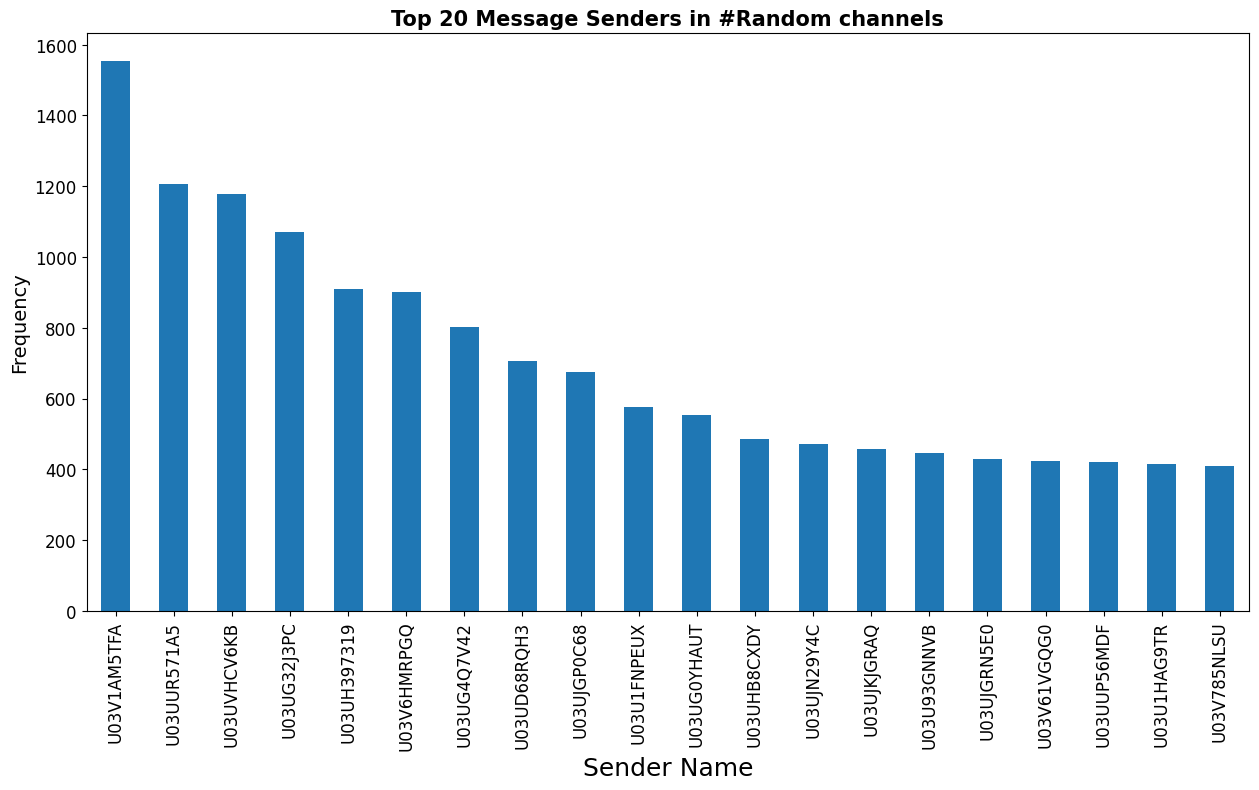

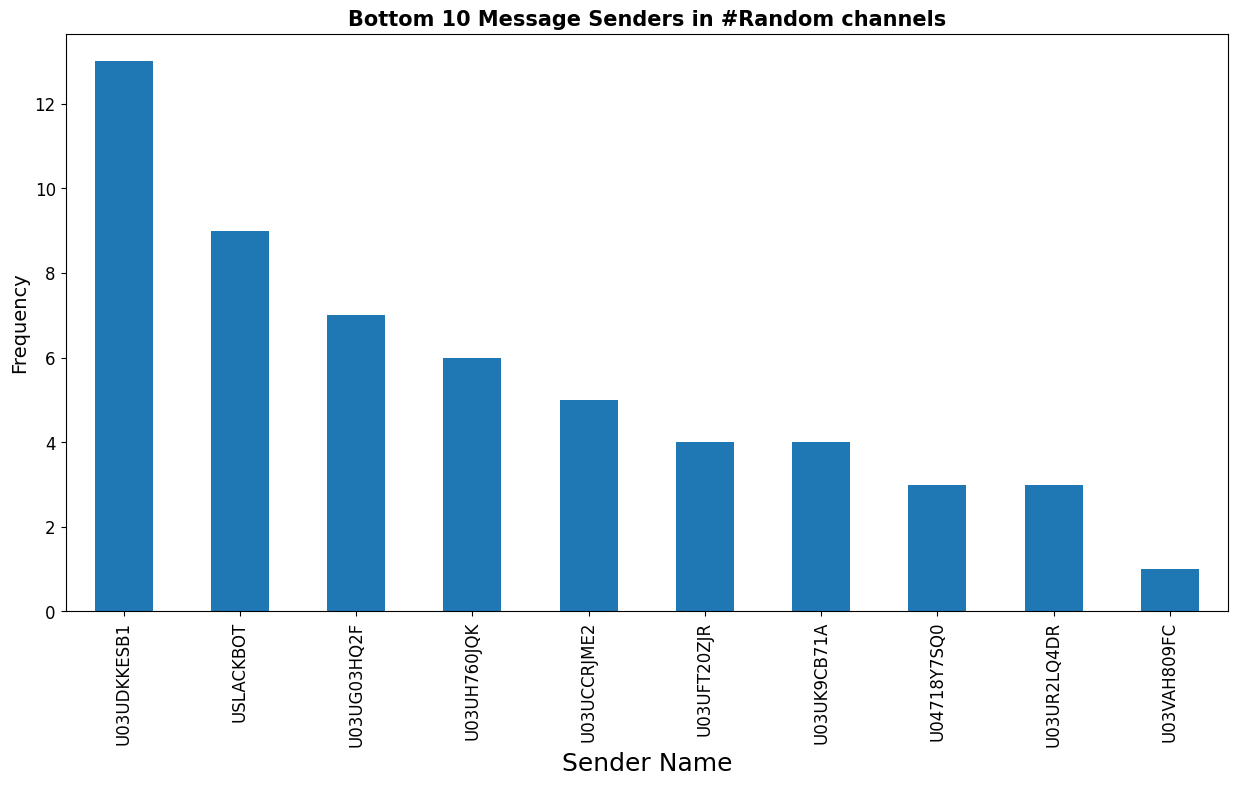

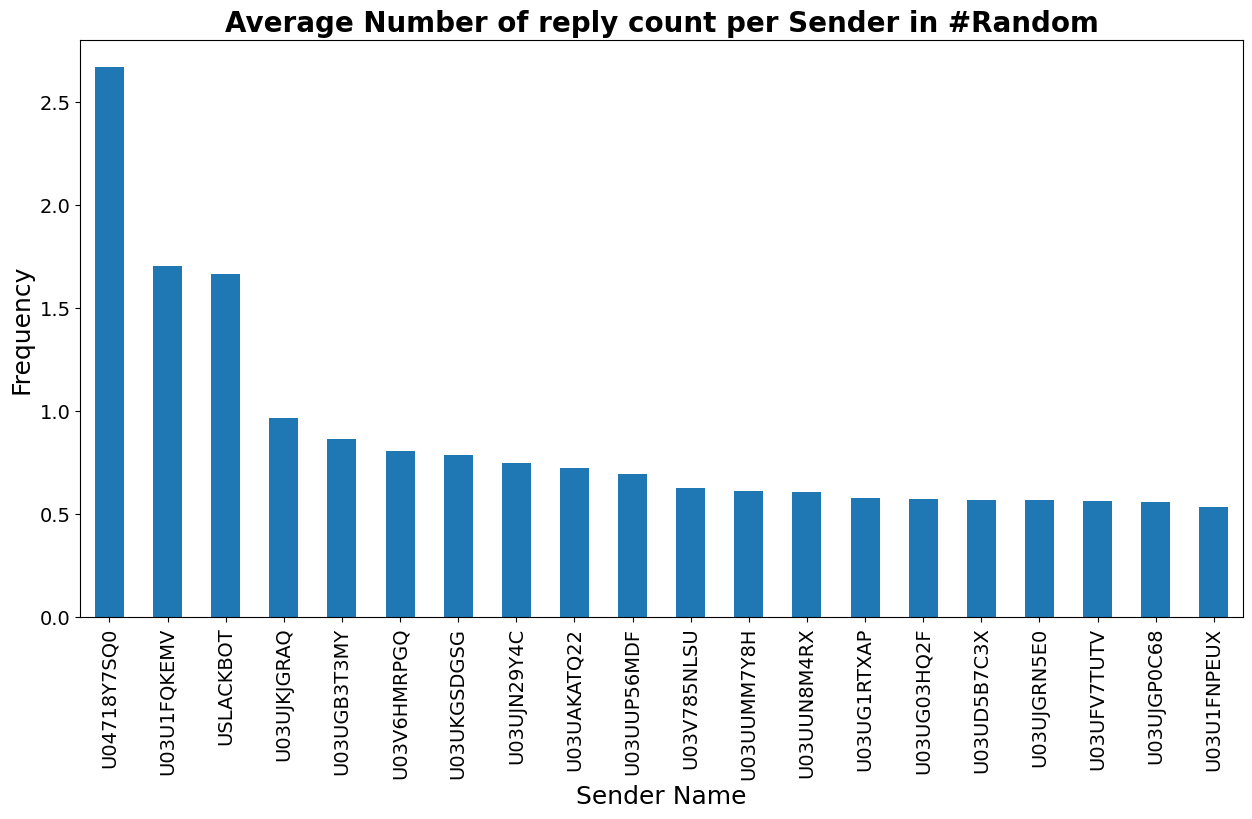

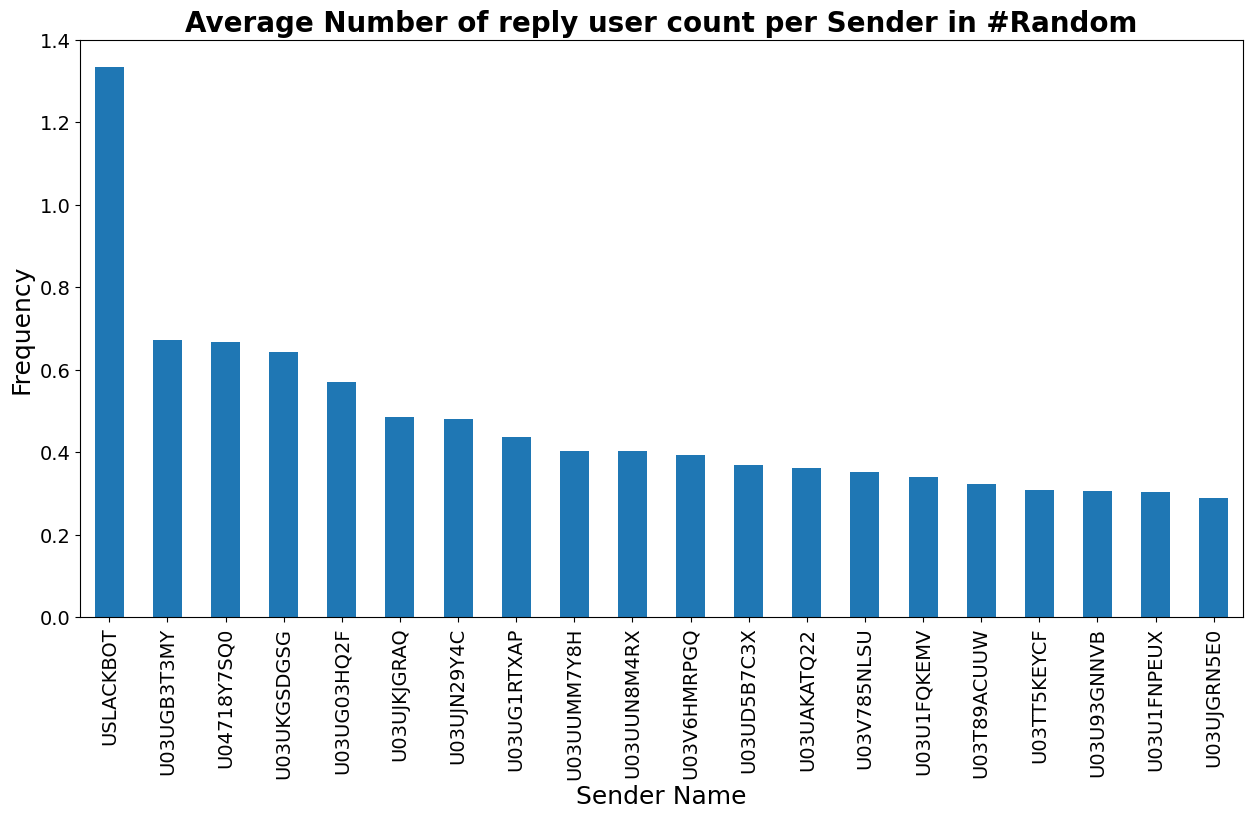

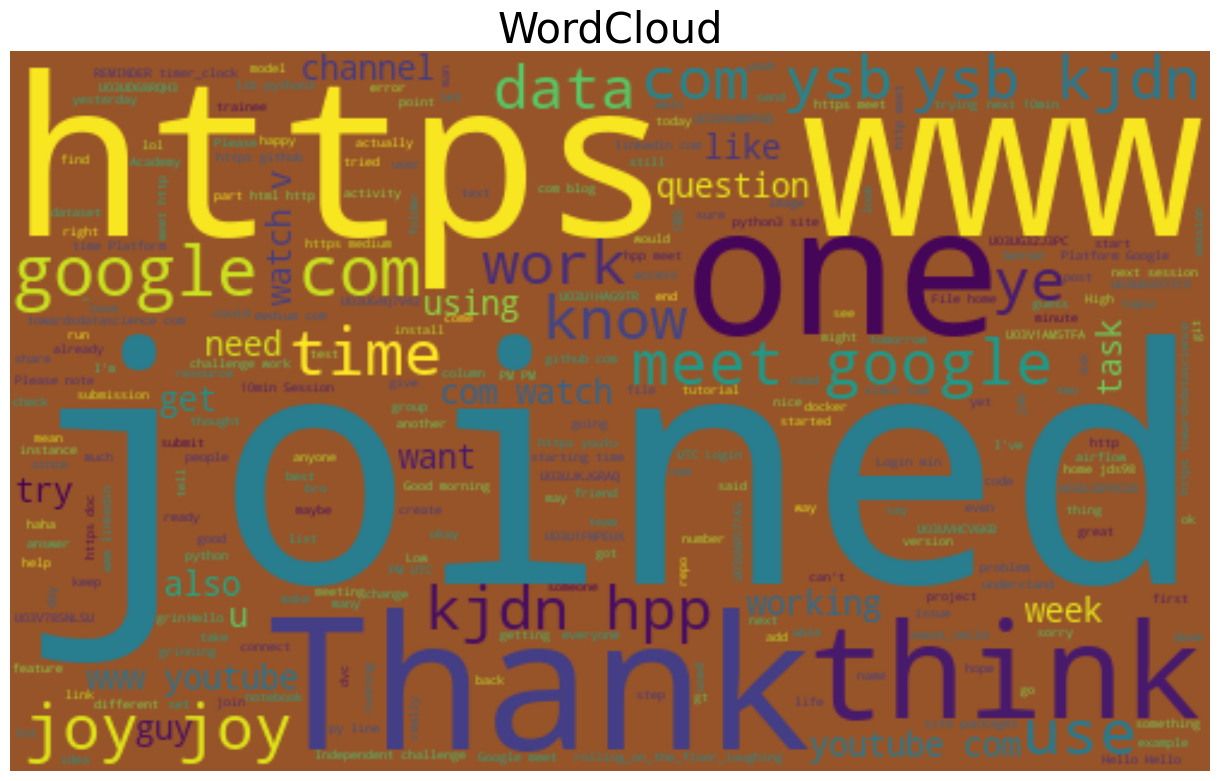

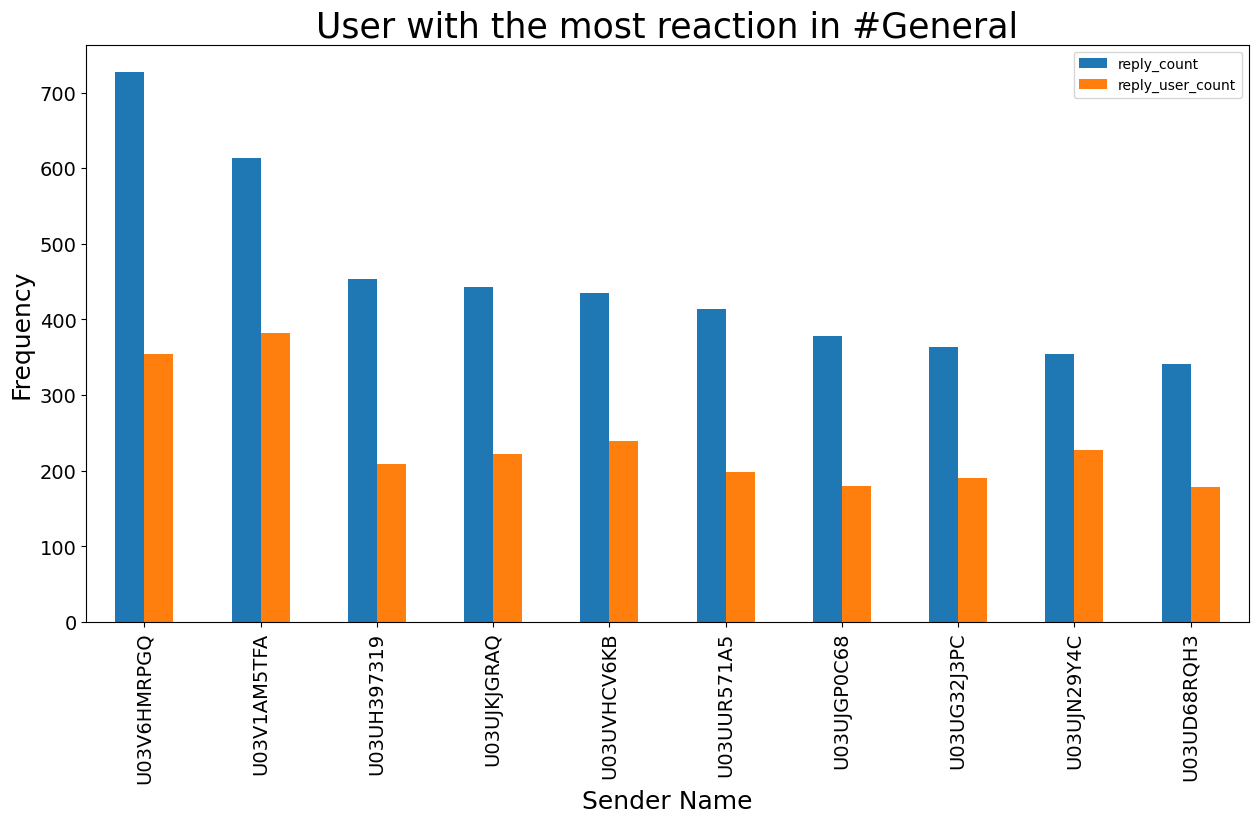

In [53]:
def get_top_20_user(data, channel='Random'):
    """get user with the highest number of message sent to any channel"""

    data['sender_name'].value_counts()[:20].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top 20 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

def draw_avg_reply_count(data, channel='Random'):
    """who commands many reply?"""

    data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:20]\
        .plot(kind='bar', figsize=(15,7.5));
    plt.title(f'Average Number of reply count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_avg_reply_users_count(data, channel='Random'):
    """who commands many user reply?"""

    data.groupby('sender_name')['reply_user_count'].mean().sort_values(ascending=False)[:20].plot(kind='bar',
     figsize=(15,7.5));
    plt.title(f'Average Number of reply user count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_wordcloud(msg_content):    
    # word cloud visualization
    allWords = ' '.join([twts for twts in msg_content])
    wordCloud = WordCloud(background_color='#975429', width=500, height=300, random_state=21, max_words=500, mode='RGBA',
                            max_font_size=140, stopwords=stopwords.words('english')).generate(allWords)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'WordCloud', size=30)
    plt.show()

def draw_user_reaction(data, channel='General'):
    data.groupby('sender_name')[['reply_count', 'reply_user_count']].sum()\
        .sort_values(by='reply_count',ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
    plt.title(f'User with the most reaction in #{channel}', size=25);
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

get_top_20_user(combined_df)
draw_avg_reply_count(combined_df)
draw_avg_reply_users_count(combined_df)
draw_wordcloud(combined_df['message_content'])
draw_user_reaction(combined_df)

## Insight Extraction

Below are some useful questions to answer. Feel free to explore to answer other interesting questions that may be of help to get insight about student's behaviour, need, and future performance 

In [54]:
# which user has the highest number of reply counts?
user_reply_counts = combined_df.groupby('sender_name')['reply_count'].sum()
top_user_reply_count = user_reply_counts.idxmax()
print(f"The user with the highest number of reply counts is: {top_user_reply_count}")

The user with the highest number of reply counts is: U03V6HMRPGQ


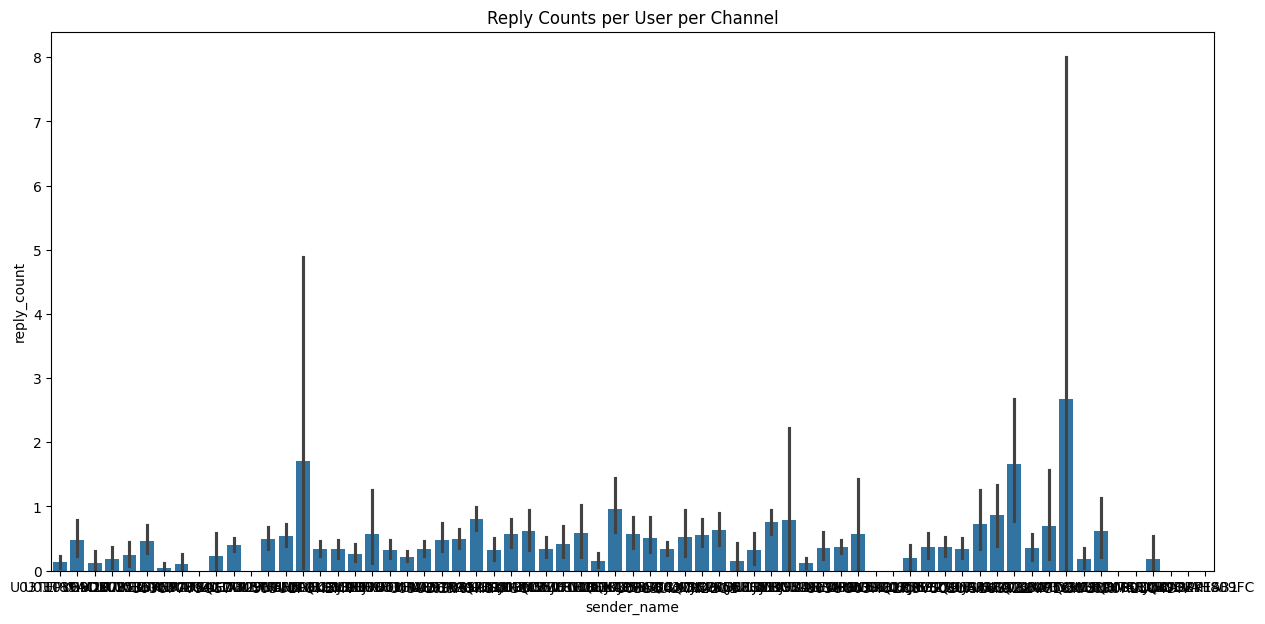

In [55]:
# Visualize reply counts per user per channel
plt.figure(figsize=(15, 7))
sns.barplot(x='sender_name', y='reply_count', data=combined_df)
plt.title('Reply Counts per User per Channel')
plt.show()


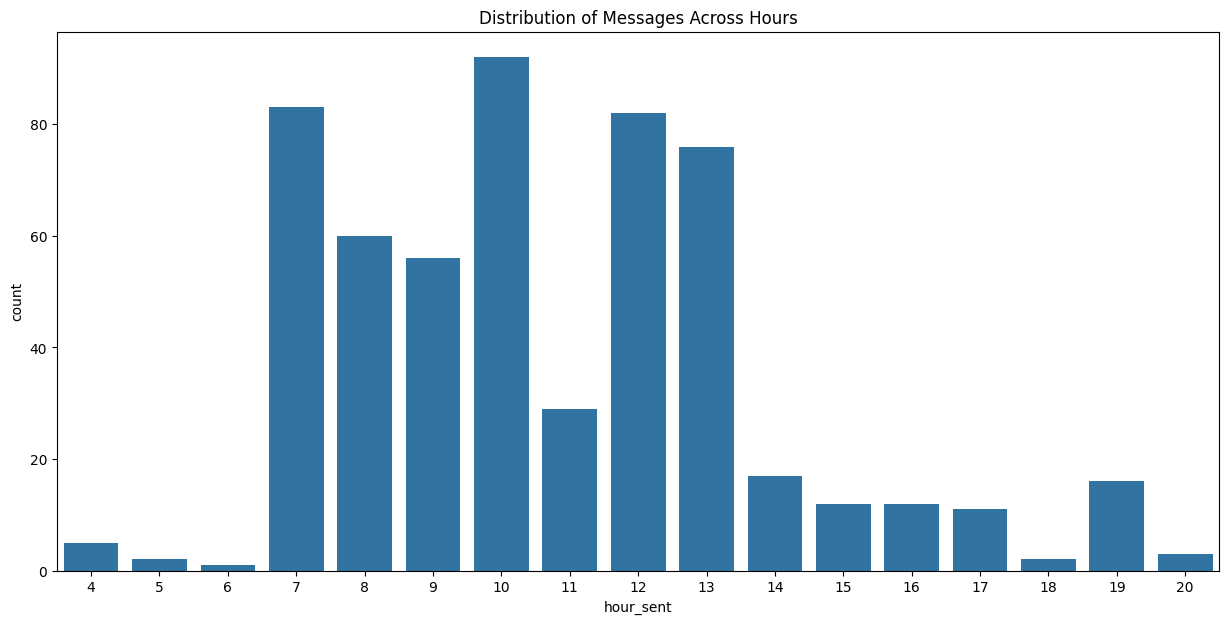

In [56]:
# what is the time range of the day that most messages are sent?
df['time_sent'] = pd.to_datetime(df['time_sent'], unit='s')
df['hour_sent'] = df['time_sent'].dt.hour
plt.figure(figsize=(15, 7))
sns.countplot(x='hour_sent', data=df)
plt.title('Distribution of Messages Across Hours')
plt.show()

In [57]:
# what kind of messages are replied faster than others?

# Convert 'time_sent' to datetime format
combined_df['time_sent'] = pd.to_datetime(combined_df['time_sent'], unit='s')

# Calculate time differences for each message type
combined_df['time_diff_reply'] = combined_df.groupby('message_type')['time_sent'].diff()

#Calculate time differences for each message type
average_time_diff = combined_df.groupby('message_type')['time_diff_reply'].mean()

min_mean_message_type = average_time_diff.idxmin()

print(f"The message_type with the smallest mean time difference is: {min_mean_message_type}")


The message_type with the smallest mean time difference is: message


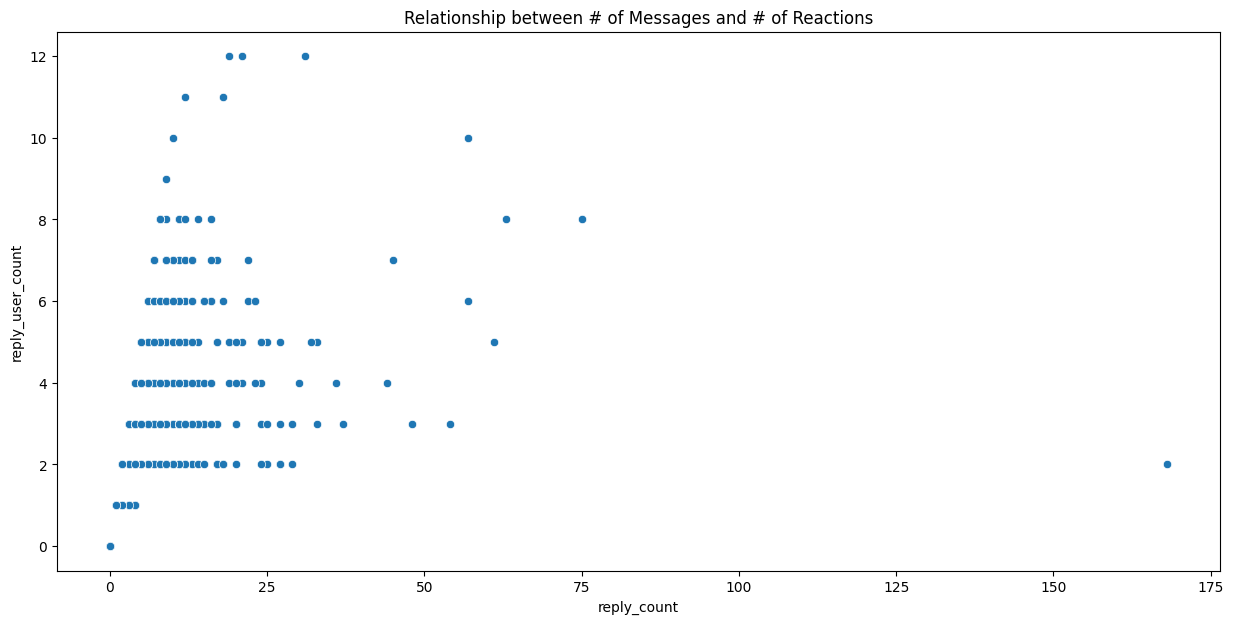

In [58]:
# Relationship between # of messages and # of reactions
plt.figure(figsize=(15, 7))
sns.scatterplot(x='reply_count', y='reply_user_count', data=combined_df)
plt.title('Relationship between # of Messages and # of Reactions')
plt.show()

In [59]:
# Classify messages into different categories such as questions, answers, comments, etc.
import pandas as pd

def classify_message(message_content):
    # Define keywords for each category
    question_keywords = ['?', 'how', 'what', 'why', 'when', 'where', 'who']
    answer_keywords = ['answer:', 'solution:', 'reply:', 'resolved:']
    comment_keywords = ['comment:', 'feedback:', 'thoughts:', 'suggestion:']
    channel_joined = ['has joined the channel']

    # Convert the message content to lowercase for case-insensitive matching
    message_content_lower = message_content.lower()

    # Check for keywords and assign a category
    if any(keyword in message_content_lower for keyword in question_keywords):
        return 'Question'
    elif any(keyword in message_content_lower for keyword in answer_keywords):
        return 'Answer'
    elif any(keyword in message_content_lower for keyword in comment_keywords):
        return 'Comment'
    elif any(keyword in message_content_lower for keyword in channel_joined):
        return 'channel Joined'
    else:
        return 'Other'

# Apply the classification function to the 'message_content' column
combined_df['message_category'] = combined_df['message_content'].apply(classify_message)

# Display the DataFrame with the new 'message_category' column
print(combined_df[['message_content', 'message_category']])


                             message_content message_category
0      <@U03TEPYRM2P> has joined the channel   channel Joined
1      <@U03T89ACUUW> has joined the channel   channel Joined
2      <@U03U9DB7REG> has joined the channel   channel Joined
3      <@U03UKL27B0R> has joined the channel   channel Joined
4      <@U03UL5LSTG9> has joined the channel   channel Joined
...                                      ...              ...
20005  <@U03UUS0MZCZ> has joined the channel   channel Joined
20006  <@U03UG4Q7V42> has joined the channel   channel Joined
20007  <@U03U9DB7REG> has joined the channel   channel Joined
20008  <@U03UUN8M4RX> has joined the channel   channel Joined
20009  <@U03UKL27B0R> has joined the channel   channel Joined

[20010 rows x 2 columns]


In [60]:
# Which users got the most reactions?
user_reaction_counts = combined_df.groupby('sender_name')['reply_count'].sum()
top_user_reactions = user_reaction_counts.idxmax()
print(f"The user with the most reactions is: {top_user_reactions}")

The user with the most reactions is: U03V6HMRPGQ


In [61]:
# Model topics mentioned in the channel
from gensim import corpora, models

# Combine messages by channel
channel_texts = combined_df.groupby('channel_name')['message_content'].apply(lambda x: ' '.join(x)).reset_index()

# Tokenize and preprocess the text
texts = [message.split() for message in channel_texts['message_content']]

# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(texts)

# Convert the dictionary to a bag-of-words corpus
corpus = [dictionary.doc2bow(text) for text in texts]

# Apply the LDA model
lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

# Extract and print the topics
for idx, topic in lda_model.print_topics():
    print(f'Topic {idx + 1}: {topic}')

# Assign topics to each message in the original DataFrame
combined_df['message_topic'] = combined_df['message_content'].apply(lambda x: lda_model[dictionary.doc2bow(x.split())][0][0])

# Display the DataFrame with the new 'message_topic' column
print(combined_df[['message_content', 'message_topic']])


Topic 1: 0.001*"the" + 0.000*"to" + 0.000*"you" + 0.000*"I" + 0.000*"in" + 0.000*"is" + 0.000*"that" + 0.000*"and" + 0.000*"a" + 0.000*"of"
Topic 2: 0.014*"the" + 0.008*"in" + 0.008*"to" + 0.006*"has" + 0.006*"File" + 0.006*"line" + 0.005*"channel" + 0.005*"joined" + 0.005*"this" + 0.005*"for"
Topic 3: 0.052*"the" + 0.025*"to" + 0.023*"I" + 0.018*"you" + 0.014*"and" + 0.014*"is" + 0.012*"it" + 0.012*"a" + 0.010*"has" + 0.010*"for"
Topic 4: 0.025*"the" + 0.024*"I" + 0.019*"to" + 0.016*"you" + 0.014*"is" + 0.014*"and" + 0.013*"a" + 0.010*"of" + 0.009*"for" + 0.008*"in"
Topic 5: 0.033*"the" + 0.020*"•" + 0.015*"in" + 0.014*"to" + 0.013*"that" + 0.012*"is" + 0.011*"on" + 0.011*"next" + 0.010*"-" + 0.010*"PM"
                             message_content  message_topic
0      <@U03TEPYRM2P> has joined the channel              0
1      <@U03T89ACUUW> has joined the channel              0
2      <@U03U9DB7REG> has joined the channel              0
3      <@U03UKL27B0R> has joined the channel  

In [62]:
# What are the topics that got the most reactions?
from gensim import corpora, models

# Combine messages by channel
channel_texts = combined_df.groupby('channel_name')['message_content'].apply(lambda x: ' '.join(x)).reset_index()

# Tokenize and preprocess the text
texts = [message.split() for message in channel_texts['message_content']]

# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(texts)

# Convert the dictionary to a bag-of-words corpus
corpus = [dictionary.doc2bow(text) for text in texts]

# Apply the LDA model
lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

# Extract and print the topics
for idx, topic in lda_model.print_topics():
    print(f'Topic {idx + 1}: {topic}')

# Assign topics to each message in the original DataFrame
combined_df['message_topic'] = combined_df['message_content'].apply(lambda x: lda_model[dictionary.doc2bow(x.split())][0][0])

# Count the number of reactions for each topic
topic_reactions_count = combined_df.groupby('message_topic')['reply_count'].sum()

# Display the topics with the most reactions
top_topics = topic_reactions_count.nlargest(5)  # Adjust the number based on your preference
print("Top Topics by Reactions:")
print(top_topics)


Topic 1: 0.052*"the" + 0.025*"to" + 0.024*"I" + 0.018*"you" + 0.014*"and" + 0.013*"it" + 0.013*"is" + 0.012*"a" + 0.010*"for" + 0.010*"we"
Topic 2: 0.039*"the" + 0.031*"has" + 0.031*"channel" + 0.031*"joined" + 0.009*"in" + 0.006*"line" + 0.006*"File" + 0.006*"to" + 0.004*"you" + 0.004*"of"
Topic 3: 0.035*"the" + 0.019*"to" + 0.016*"•" + 0.014*"in" + 0.013*"is" + 0.012*"that" + 0.011*"on" + 0.010*"you" + 0.010*"-" + 0.009*"a"
Topic 4: 0.000*"the" + 0.000*"to" + 0.000*"you" + 0.000*"I" + 0.000*"and" + 0.000*"is" + 0.000*"in" + 0.000*"of" + 0.000*"a" + 0.000*"for"
Topic 5: 0.028*"the" + 0.024*"I" + 0.020*"to" + 0.016*"you" + 0.014*"is" + 0.014*"and" + 0.013*"a" + 0.010*"of" + 0.009*"for" + 0.008*"in"
Top Topics by Reactions:
message_topic
0    7780
4     848
2     256
1       9
Name: reply_count, dtype: int64


### Harder questions to look into

In [63]:
# Based on messages, reactions, references shared, and other relevant data such as classification of questions into techical question, comment, answer, aorder stu the python, statistics, and sql skill level of a user?




# Classify messages into categories
def classify_message(message):
    if 'python' in message.lower():
        return 'Python Question'
    elif 'sql' in message.lower():
        return 'SQL Question'
    elif 'statistics' in message.lower():
        return 'Statistics Question'
    else:
        return 'Other'

combined_df['message_category'] = combined_df['message_content'].apply(classify_message)

# Skill Level Analysis
python_skill_users = combined_df[combined_df['message_content'].str.contains('python', case=False)]['sender_name'].unique()
sql_skill_users = combined_df[combined_df['message_content'].str.contains('sql', case=False)]['sender_name'].unique()
statistics_skill_users = combined_df[combined_df['message_content'].str.contains('statistics', case=False)]['sender_name'].unique()

print("Users with Python Skills:", python_skill_users)
print("Users with SQL Skills:", sql_skill_users)
print("Users with Statistics Skills:", statistics_skill_users)



Users with Python Skills: ['U03U1HAG9TR' 'U03V1AM5TFA' 'U03U9FWPNCE' 'U03UVHCV6KB' 'U03UUMR26Q1'
 'U03U93GNNVB' 'U03UG4Q7V42' 'U03U1FNPEUX' 'U03U9EJR362' 'U03UJGRN5E0'
 'U03UD5B7C3X' 'U03UG0YHAUT' 'U03UUR571A5' 'U03V61VGQG0' 'U03UG32J3PC'
 'U03UG0SFHGT' 'U03UG569P7U' 'U03UJKJGRAQ' 'U03UJN29Y4C' 'U03V5Q9N516'
 'U03UFV7HFNF' 'U03UUP56MDF' 'U03UD4FEDHB' 'U03UJH1EQQL' 'U03UG1Z21JP'
 'U03UJGP0C68' 'U03V785NLSU' 'U03V8LHPDME' 'U03UHB8CXDY' 'U03UKGSDGSG'
 'U03UUMM7Y8H' 'U03UKL27B0R' 'U03UH397319' 'U03V6HMRPGQ' 'U03U1FQKEMV'
 'U03T89ACUUW' 'U03U9DB7REG' 'U03UD68RQH3' 'U03UAKATQ22']
Users with SQL Skills: ['U03UD68RQH3' 'U03U93GNNVB' 'U03UG32J3PC' 'U03UFV7HFNF' 'U03U9FWPNCE'
 'U03UUR571A5' 'U03UH397319' 'U03V5Q9N516' 'U03U9EJR362' 'U03UJH1EQQL'
 'U03UVHCV6KB' 'U03UG1Z21JP' 'U03U1HAG9TR' 'U03UD4FEDHB' 'U03UG0YHAUT'
 'U03U1FNPEUX' 'U03UJGRN5E0' 'U03U9DB7REG' 'U03UKL27B0R' 'U03V8LHPDME'
 'U03V61VGQG0' 'U03UJGP0C68' 'U03UUP56MDF' 'U03V6HMRPGQ' 'U03V785NLSU']
Users with Statistics Skills: ['U03UUR57

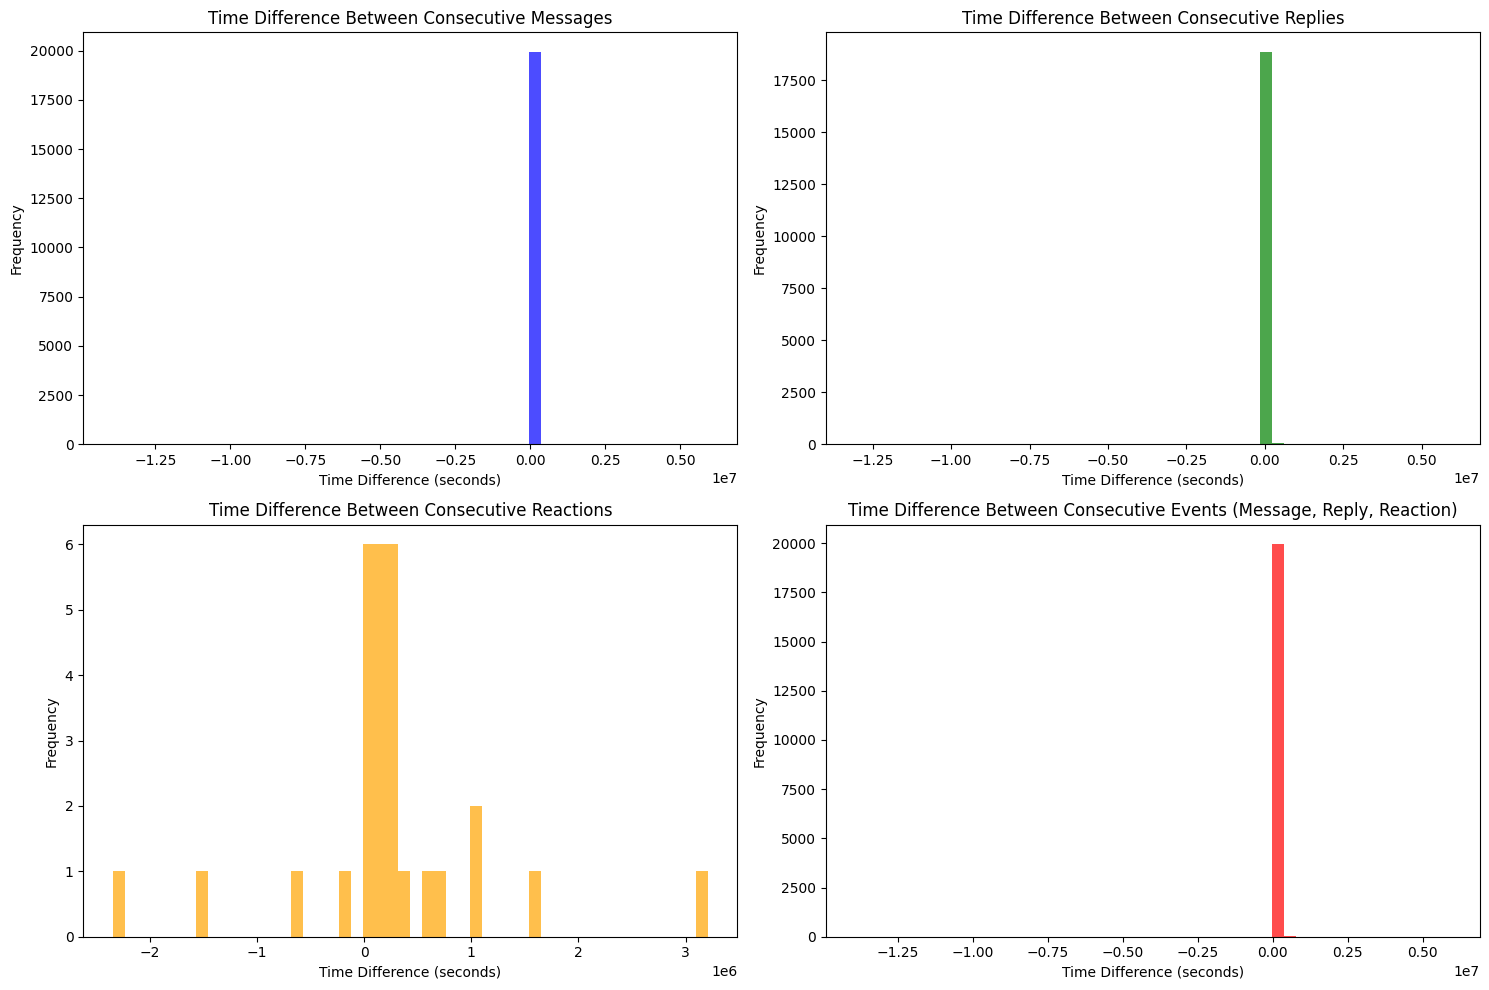

In [64]:
# Convert 'time_sent' to DateTime format
combined_df['time_sent'] = pd.to_datetime(combined_df['time_sent'], unit='s')

# Calculate time differences
combined_df['time_diff_message'] = combined_df['time_sent'].diff()
combined_df['time_diff_reply'] = combined_df[combined_df['message_type'] == 'message']['time_sent'].diff()
combined_df['time_diff_reaction'] = combined_df[combined_df['message_type'] == 'thread_broadcast']['time_sent'].diff()
combined_df['time_diff_event'] = combined_df['time_sent'].diff()



# Plot histograms
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.hist(combined_df['time_diff_message'].dt.total_seconds(), bins=50, color='blue', alpha=0.7)
plt.title('Time Difference Between Consecutive Messages')
plt.xlabel('Time Difference (seconds)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(combined_df['time_diff_reply'].dt.total_seconds(), bins=50, color='green', alpha=0.7)
plt.title('Time Difference Between Consecutive Replies')
plt.xlabel('Time Difference (seconds)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.hist(combined_df['time_diff_reaction'].dt.total_seconds(), bins=50, color='orange', alpha=0.7)
plt.title('Time Difference Between Consecutive Reactions')
plt.xlabel('Time Difference (seconds)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.hist(combined_df['time_diff_event'].dt.total_seconds(), bins=50, color='red', alpha=0.7)
plt.title('Time Difference Between Consecutive Events (Message, Reply, Reaction)')
plt.xlabel('Time Difference (seconds)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [65]:
# Message Classification

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Data Preparation
X_train, X_test, y_train, y_test = train_test_split(df['message_content'], df['message_type'], test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Model Training
classifier = MultinomialNB()
classifier.fit(X_train_vectorized, y_train)

# Evaluation
y_pred = classifier.predict(X_test_vectorized)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred, zero_division=1))


Accuracy: 0.9821428571428571
              precision    recall  f1-score   support

channel_join       1.00      0.00      0.00         2
     message       0.98      1.00      0.99       110

    accuracy                           0.98       112
   macro avg       0.99      0.50      0.50       112
weighted avg       0.98      0.98      0.97       112



In [66]:
#Topic Modeling

# Data Preparation
channel_texts = combined_df.groupby('channel_name')['message_content'].apply(lambda x: ' '.join(x)).reset_index()

# Model Training
texts = channel_texts['message_content'].apply(lambda x: x.split())
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_model = models.LdaModel(corpus, num_topics=10, id2word=dictionary)

# Extracting Top 10 Topics for each Channel
for idx, topic in lda_model.print_topics():
    print(f'Channel {idx} Topics: {topic}')


Channel 0 Topics: 0.030*"the" + 0.026*"I" + 0.019*"to" + 0.015*"you" + 0.014*"and" + 0.011*"is" + 0.010*"a" + 0.008*"in" + 0.008*"for" + 0.008*"of"
Channel 1 Topics: 0.036*"the" + 0.024*"to" + 0.017*"I" + 0.012*"you" + 0.011*"a" + 0.011*"and" + 0.011*"joined" + 0.010*"has" + 0.010*"channel" + 0.010*"is"
Channel 2 Topics: 0.025*"the" + 0.021*"to" + 0.020*"I" + 0.020*"you" + 0.016*"and" + 0.015*"is" + 0.011*"a" + 0.010*"for" + 0.008*"it" + 0.008*"of"
Channel 3 Topics: 0.045*"the" + 0.024*"to" + 0.019*"I" + 0.016*"is" + 0.014*"you" + 0.013*"a" + 0.011*"and" + 0.010*"in" + 0.010*"of" + 0.009*"that"
Channel 4 Topics: 0.043*"the" + 0.021*"to" + 0.016*"I" + 0.014*"you" + 0.014*"is" + 0.011*"a" + 0.010*"on" + 0.010*"in" + 0.010*"and" + 0.009*"for"
Channel 5 Topics: 0.038*"the" + 0.026*"to" + 0.016*"I" + 0.011*"you" + 0.011*"and" + 0.010*"in" + 0.009*"for" + 0.009*"has" + 0.009*"is" + 0.009*"channel"
Channel 6 Topics: 0.046*"the" + 0.024*"I" + 0.018*"you" + 0.018*"to" + 0.016*"and" + 0.012*"a" 

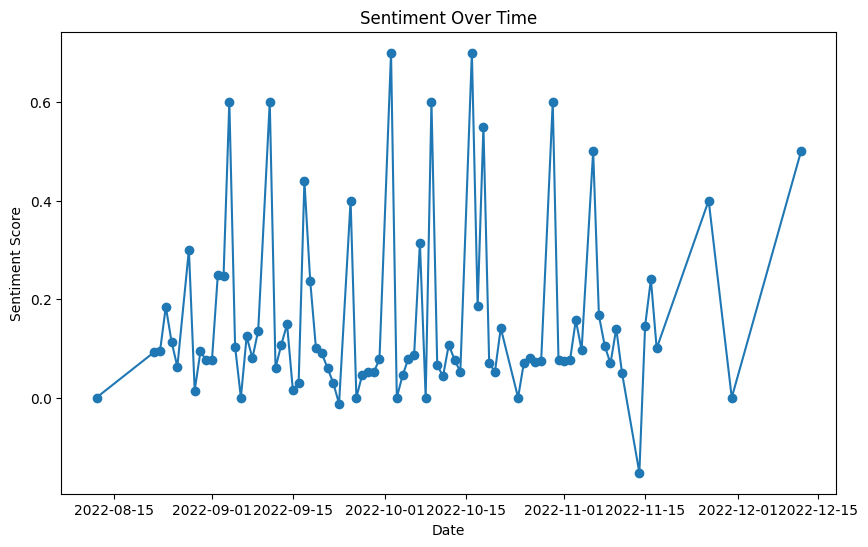

In [67]:
#Sentiment Analysis

from textblob import TextBlob
import matplotlib.pyplot as plt


# Data Preparation
df['time_sent'] = pd.to_datetime(df['time_sent']).dt.date
daily_texts = df.groupby('time_sent')['message_content'].apply(lambda x: ' '.join(x)).reset_index()

# Model Training
daily_texts['sentiment'] = daily_texts['message_content'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Analysis
plt.figure(figsize=(10, 6))
plt.plot(daily_texts['time_sent'], daily_texts['sentiment'], marker='o')
plt.title('Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')

plt.savefig("sentiment_analysis_plot.png")
plt.show()


In [68]:
import mlflow
import mlflow.sklearn  # If using scikit-learn models

# Log parameters
mlflow.log_param("model_type", "MultinomialNB")
mlflow.log_param("vectorizer_type", "TfidfVectorizer")
mlflow.log_param("num_topics", 10)

# Save LDA model to a file
lda_model.save("lda_model")

# Log LDA model
mlflow.log_artifact("lda_model", "artifacts")



# Log sentiment analysis plot
mlflow.log_artifact("sentiment_analysis_plot.png", "artifacts")


